In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd

print("Hello world.")

2025-12-16 15:12:30.980858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765897951.227946      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765897951.297196      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Hello world.


In [2]:
import os
import json
import numpy as np
import cv2

def create_mask(json_file, image_shape):
    if json_file is None or not os.path.exists(json_file):
        return None
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except:
        return None
    if 'shapes' not in data or data['shapes'] is None:
        return None

    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    try:
        for shape in data['shapes']:
            points = np.array(shape.get('points', []), dtype=np.int32)
            if len(points) > 2:
                cv2.fillPoly(mask, [points], 255)
    except:
        return None

    return mask


def find_image_file(base_name, image_path):
    """Find the correct image file (.jpg, .JPG, .jpeg, .JPEG, .png)"""
    exts = [".jpg", ".JPG", ".jpeg", ".JPEG", ".png"]
    for ext in exts:
        file_path = os.path.join(image_path, base_name + ext)
        if os.path.exists(file_path):
            return file_path
    return None

print("Hello world")

Hello world


In [3]:
train_images, valid_images, test_images  = [], [], []
train_masks, valid_masks, test_masks = [], [] , []
test_images_a, test_images_b, test_images_d = [], [], []
test_masks_a, test_masks_b, test_masks_d = [], [], []

image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset_Original_Data/Malabar_Dataset/Anthracnose(102)"
json_path = "/kaggle/input/annotated-dataset-json-files-version-2/annotated_json_files/Anthracnose(102)/affected_region"
split_file = pd.read_csv("/kaggle/input/malabar-dataset/anthracnose_split.csv")


for i in range(0, len(split_file)):
    used_for = split_file.iloc[i]["used_for"]
    image_no = split_file.iloc[i]["image_no"]
    base_name = f"Anthracnose ({image_no})"

    json_file = os.path.join(json_path, base_name + ".json")

    # --- FIND REAL IMAGE FILE ---
    image_file = find_image_file(base_name, image_path)
    if image_file is None:
        print(f"Image missing: {base_name}")
        continue

    image = cv2.imread(image_file)
    if image is None:
        print(f"Failed to read: {image_file}")
        continue

    mask = create_mask(json_file, image.shape)
    if mask is None:
        print(f"Mask skipped: {json_file}")
        continue

    if used_for == "training":
        train_images.append(image)
        train_masks.append(mask)
    elif used_for == "validation":
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)
        test_images_a.append(image)
        test_masks_a.append(mask)



print(len(train_images), len(train_masks))
print(len(valid_images), len(valid_masks))
print(len(test_images), len(test_masks))

80 80
10 10
12 12


In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array


X_test, Y_test = preprocess_data(test_images, test_masks)
print("Hello world.")

Hello world.


In [5]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Load model and predict
best_model = load_model("/kaggle/input/temp-testing-dataset/attention_Unet_semi_final_best_model.keras")
predictions = best_model.predict(X_test)

# Create masks from predictions
predicted_masks = create_mask(predictions)

2025-12-16 15:13:01.925769: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1765897988.384852      98 service.cc:148] XLA service 0x7901880055b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765897988.385669      98 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1765897989.504872      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


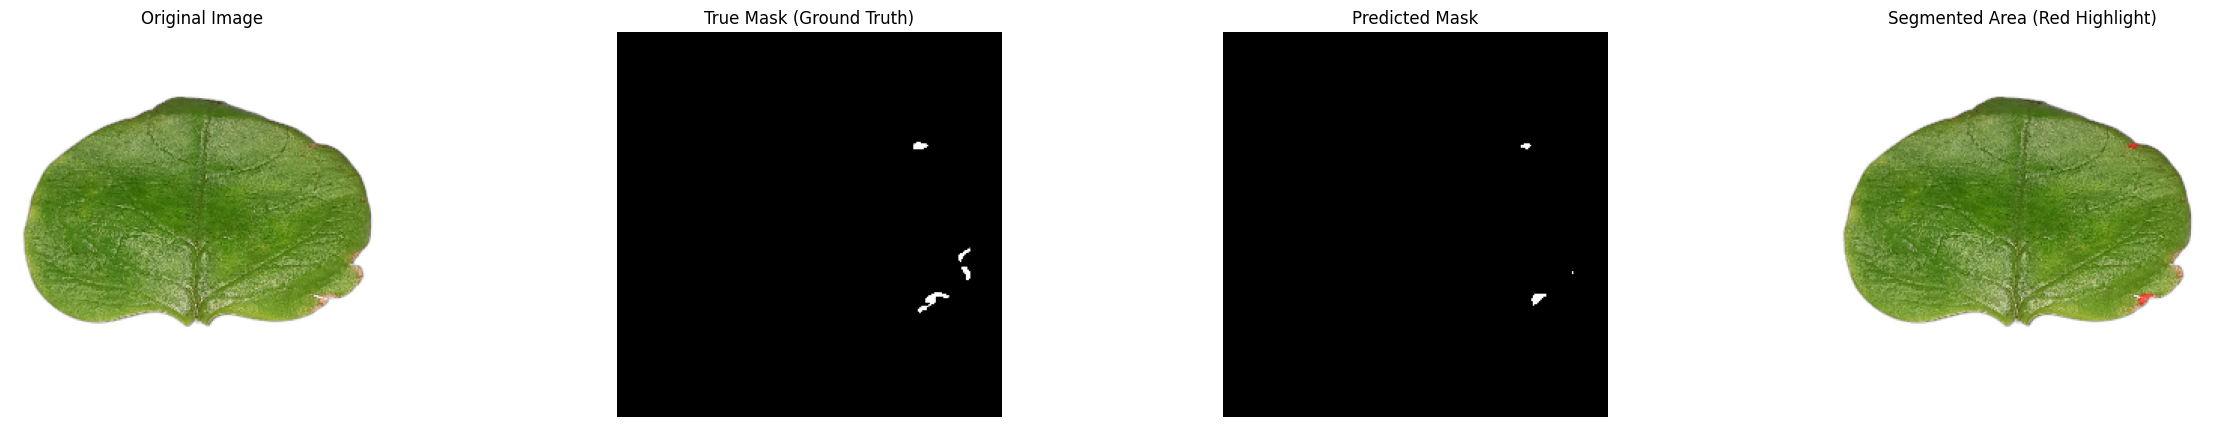

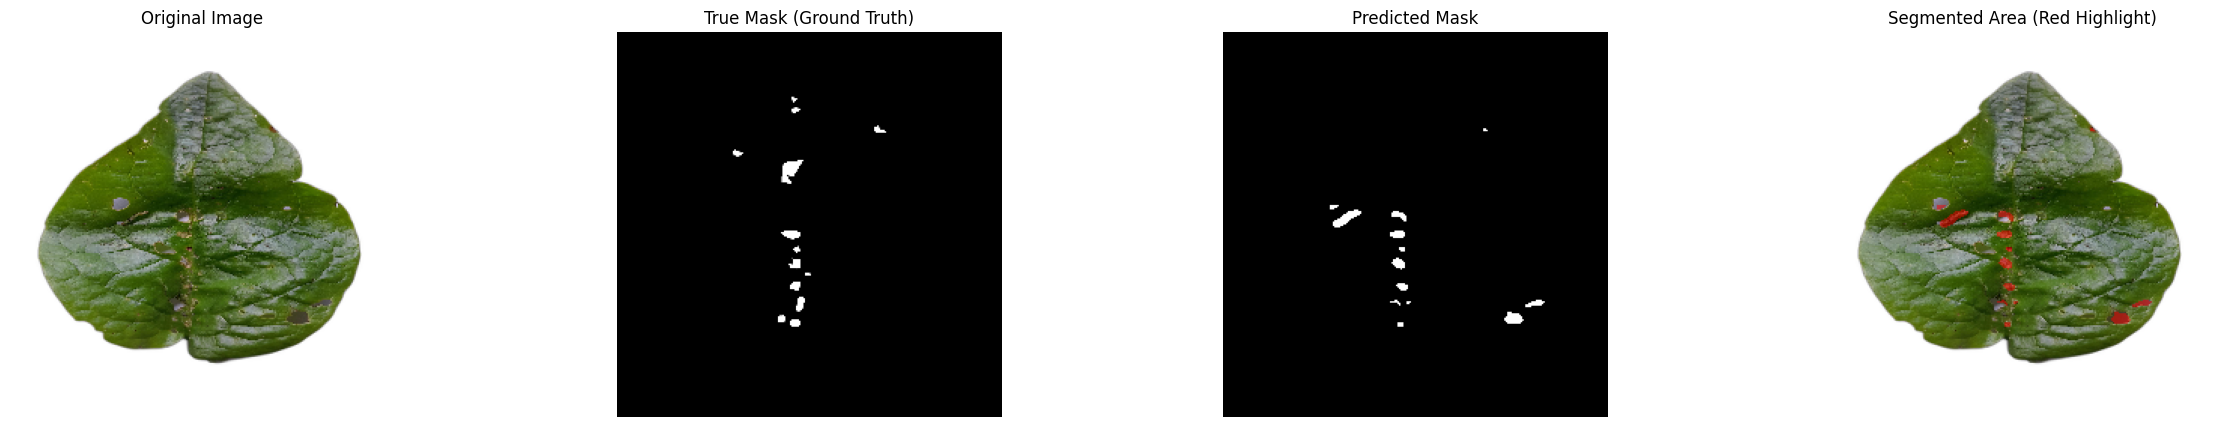

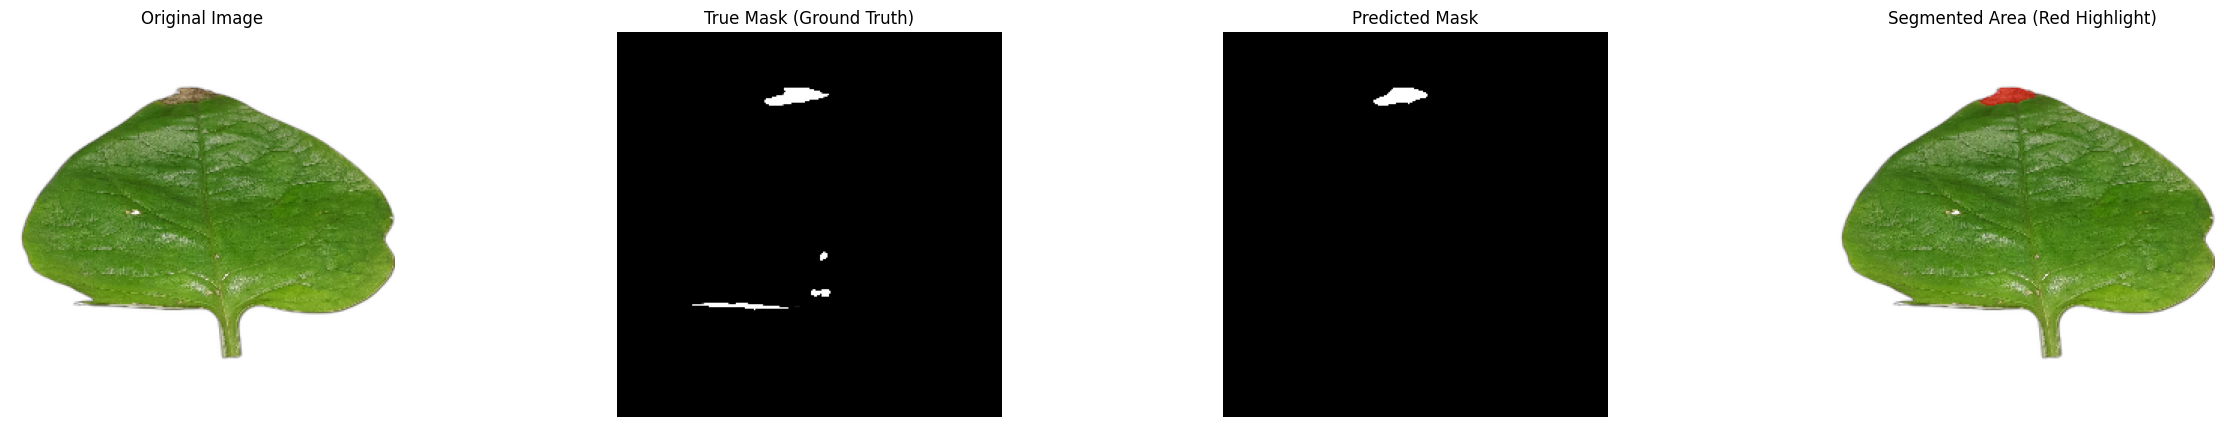

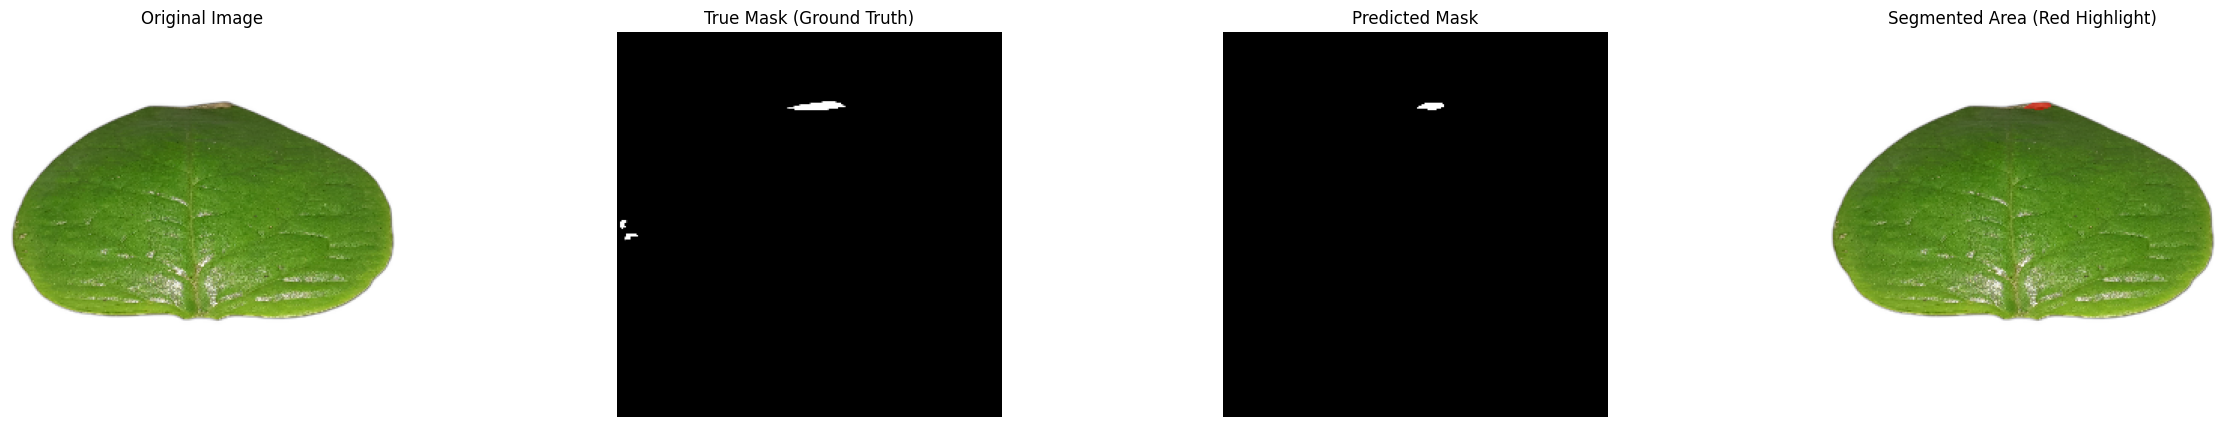

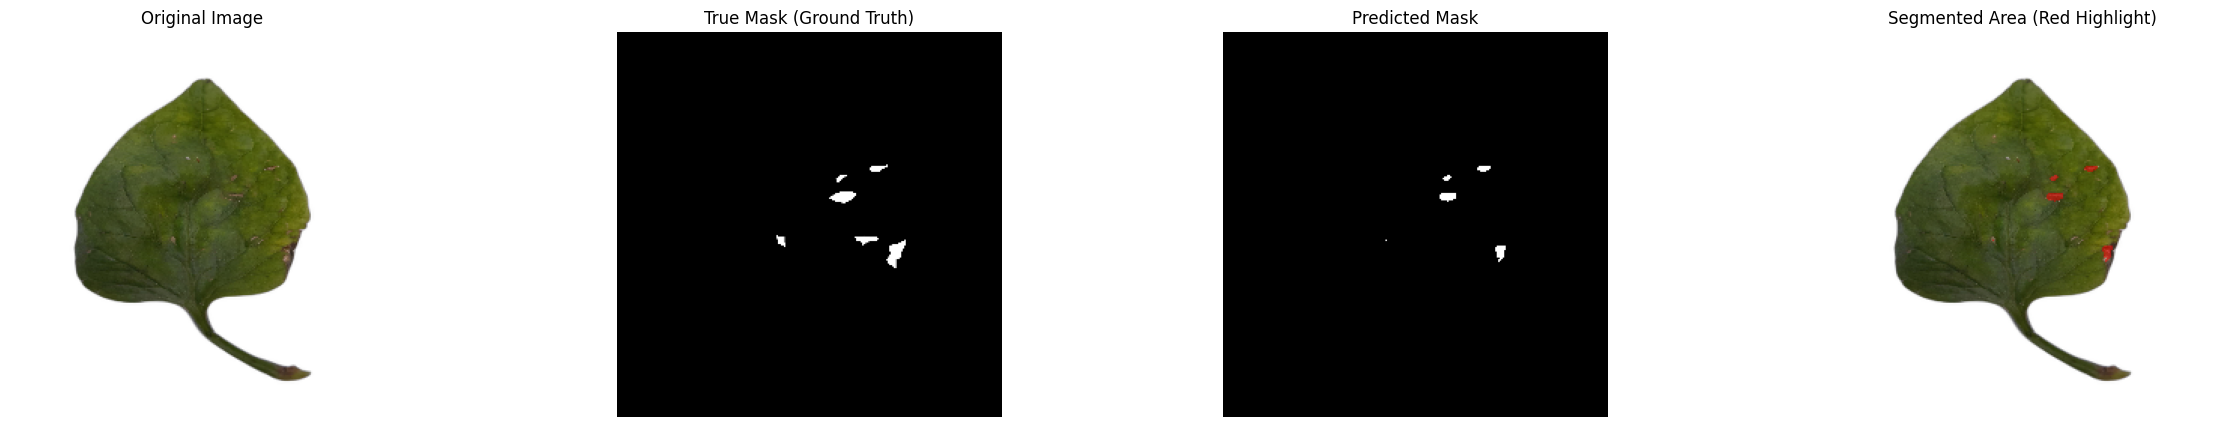

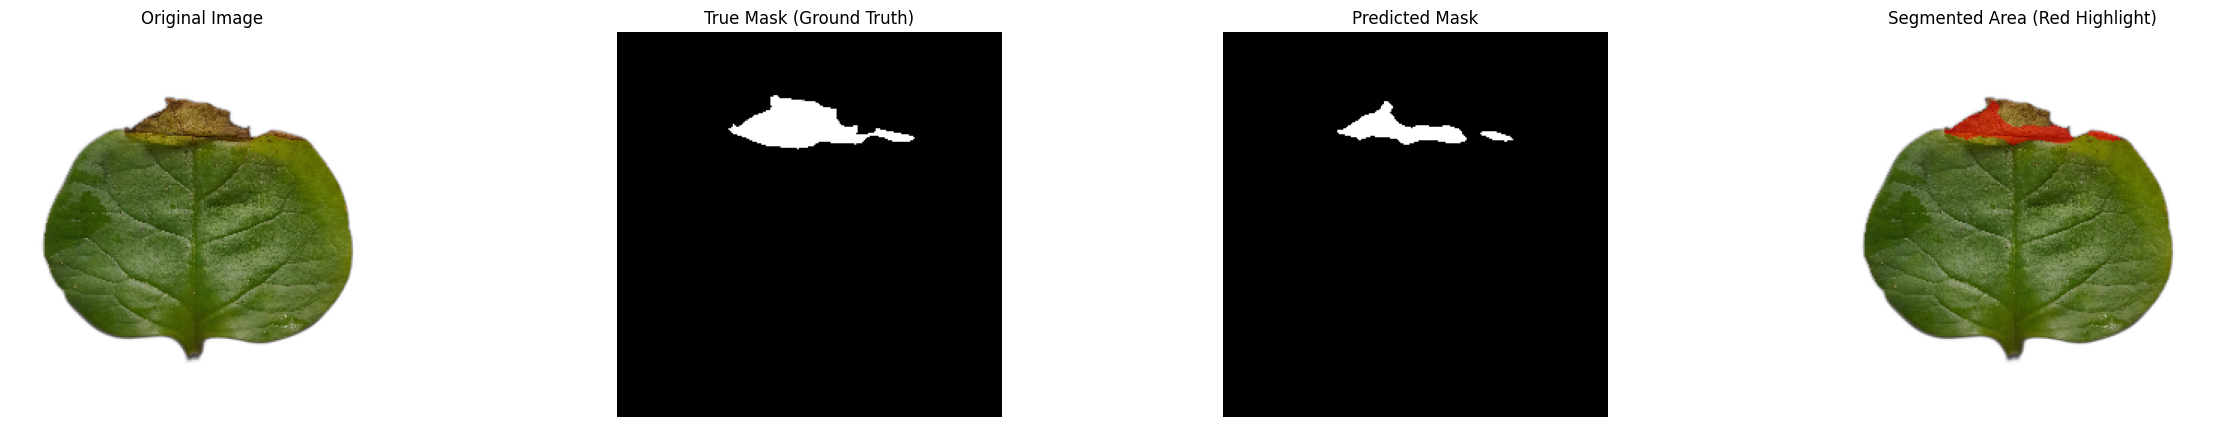

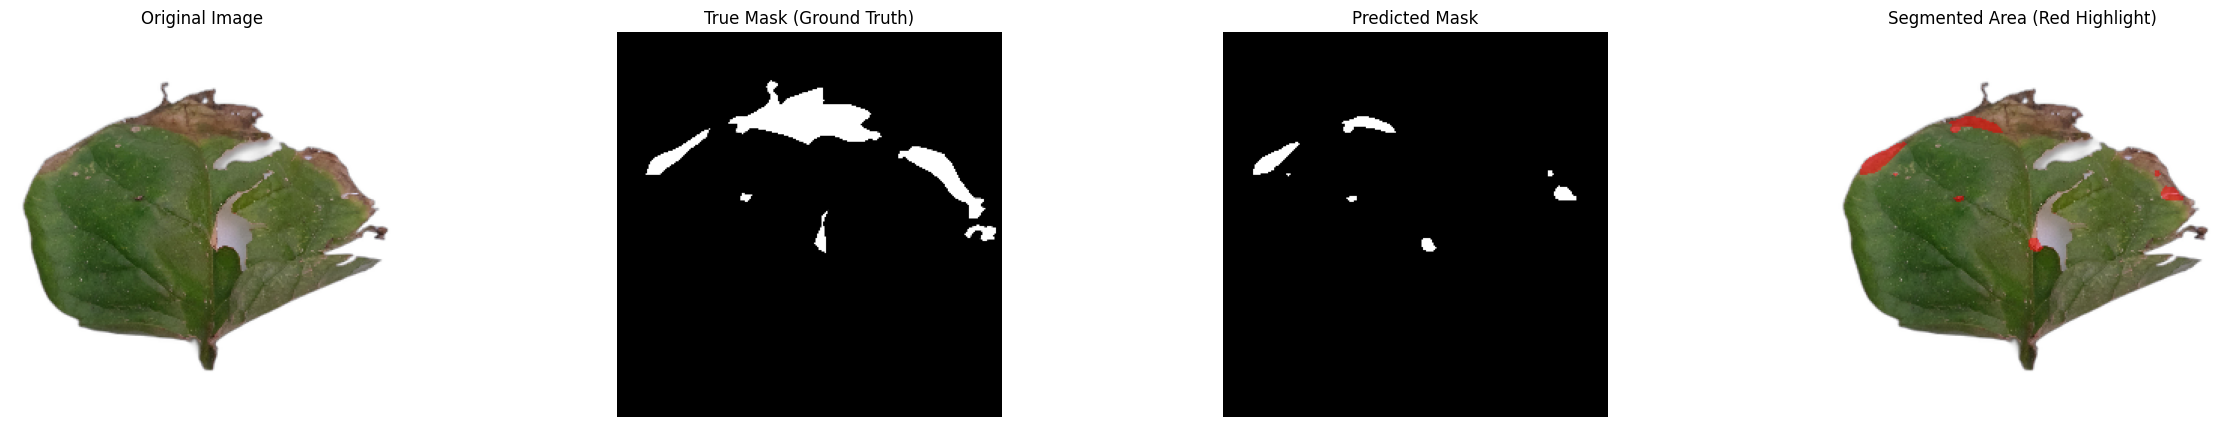

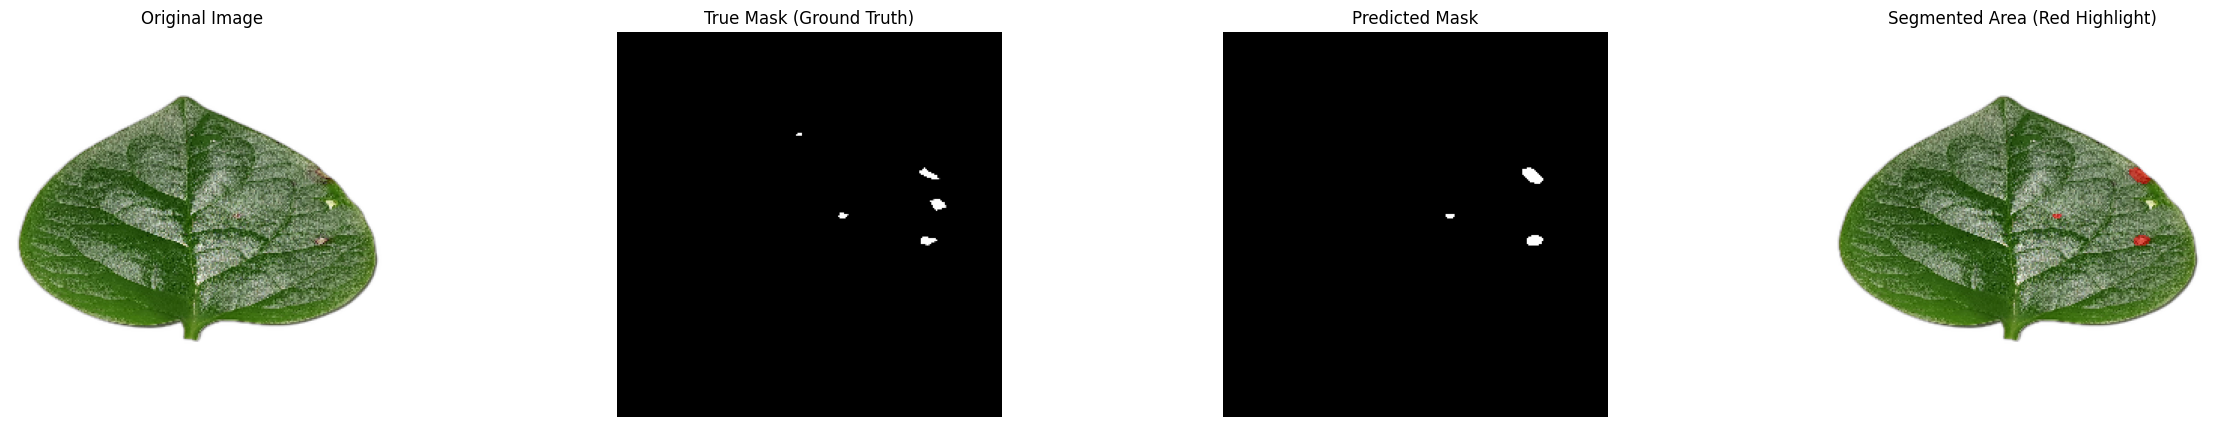

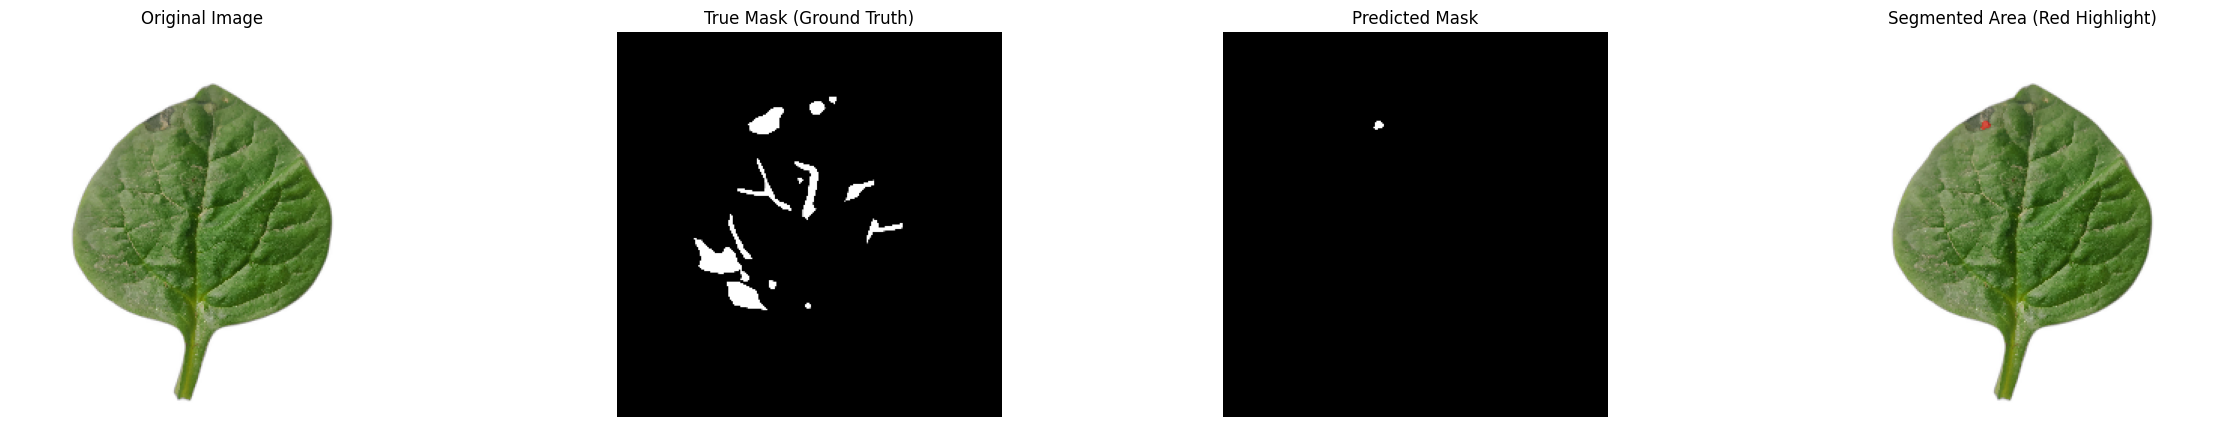

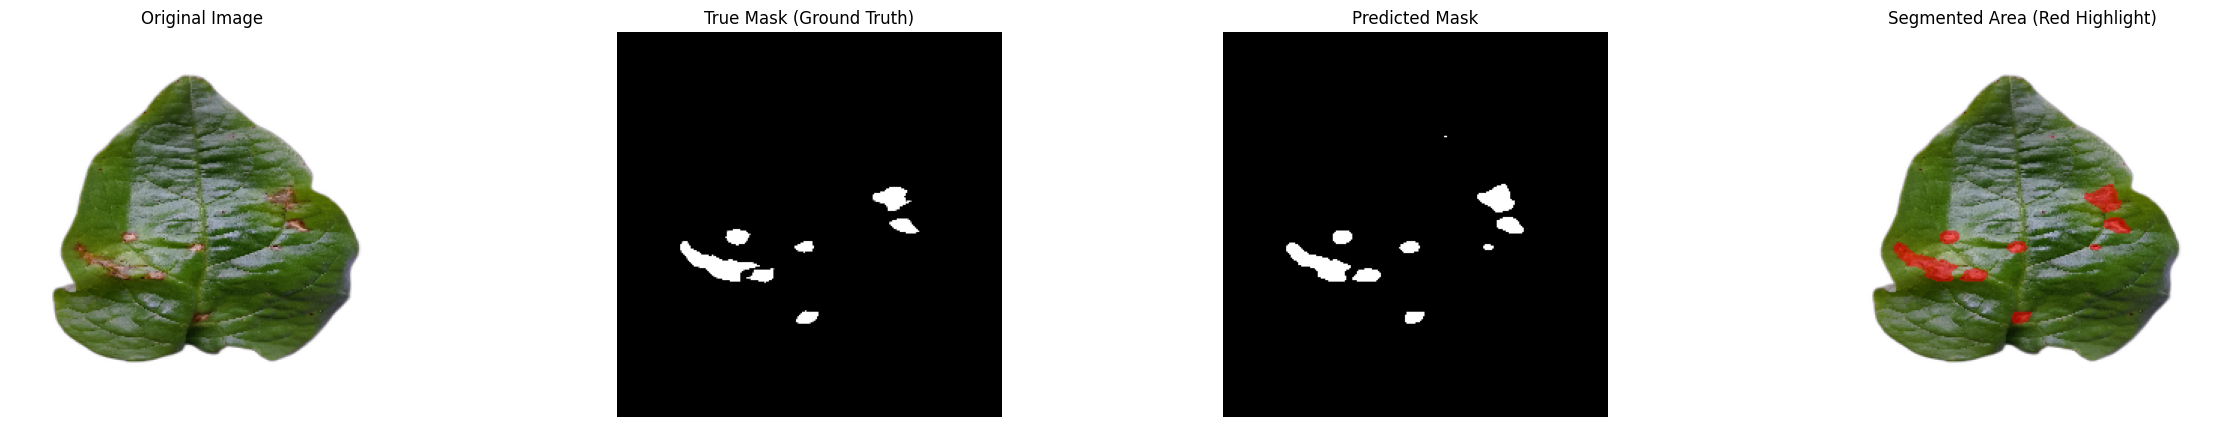

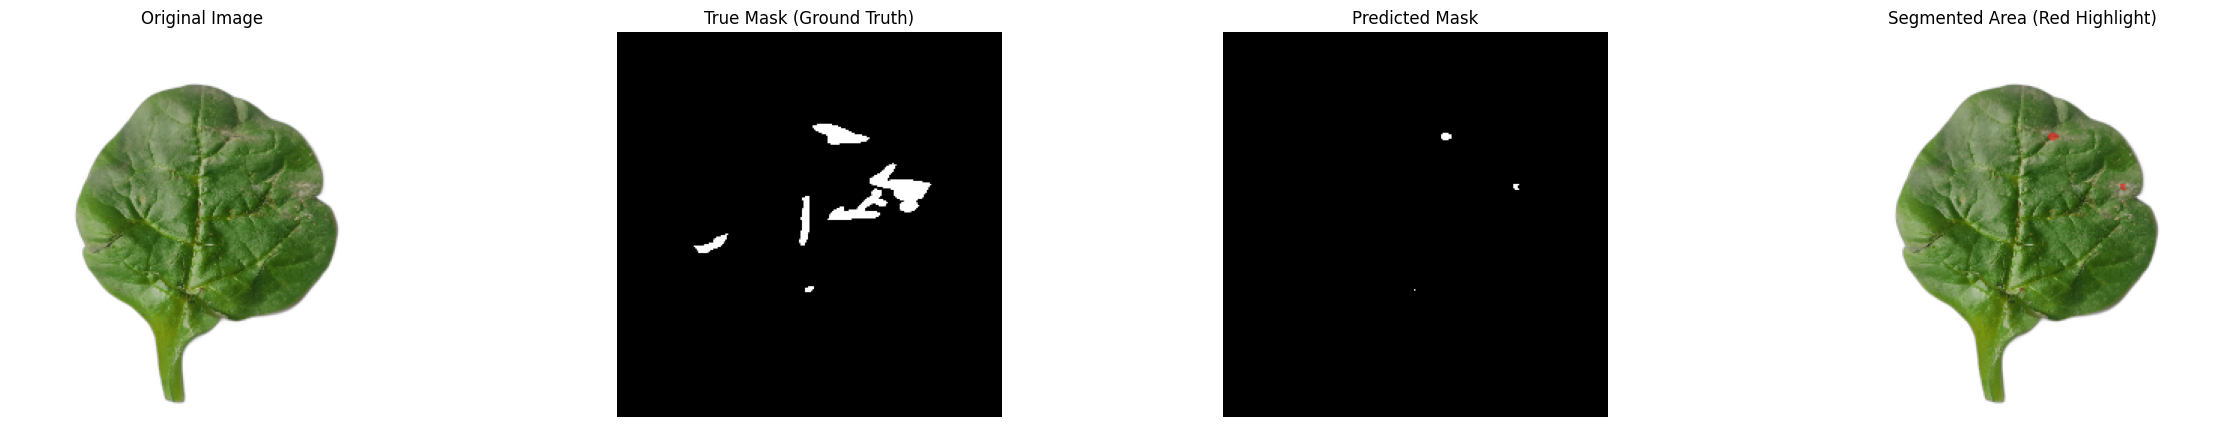

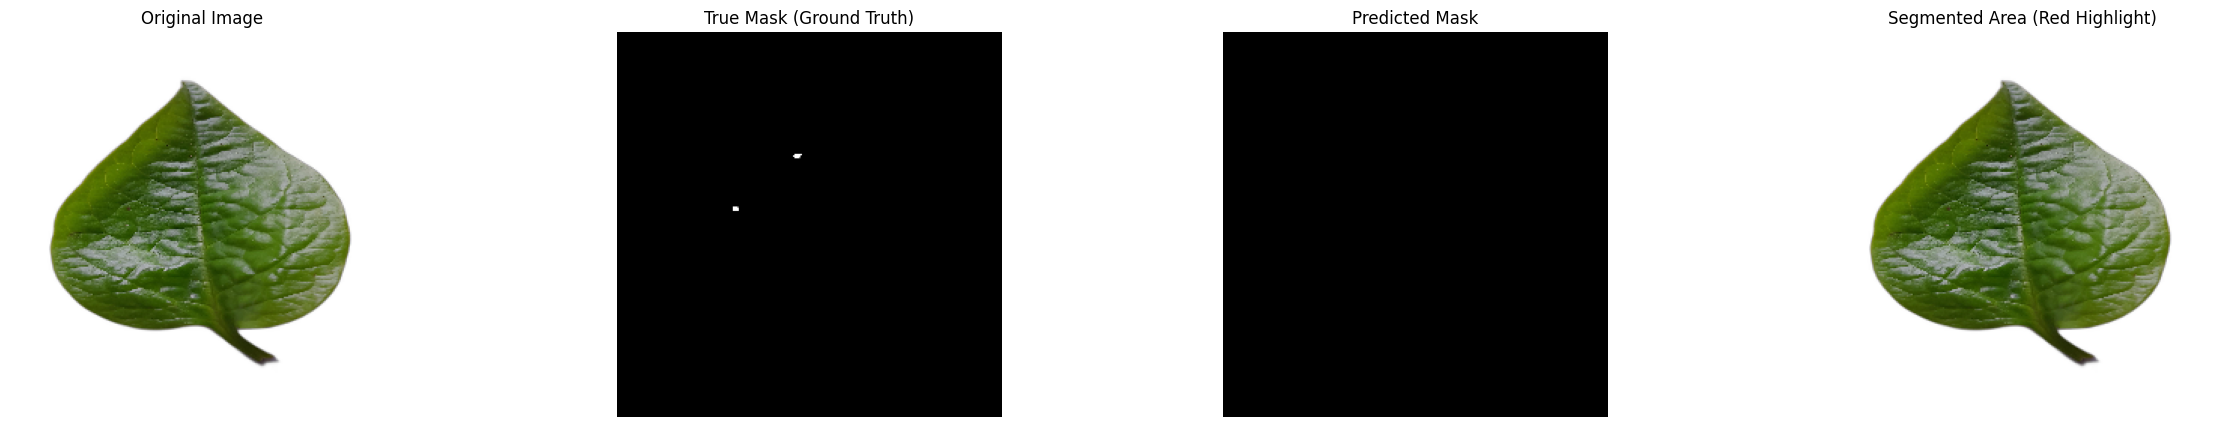

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_results(images, y_test, predicted_masks):
    for i in range(len(images)):
        img = images[i]
        true_mask = y_test[i].squeeze()
        predicted_mask = predicted_masks[i].squeeze()

        # Binary predicted mask
        pred_bin = (predicted_mask > 0.5).astype(np.uint8)

        # Ensure uint8 image
        img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img

        # ---- Red Highlight using Predicted Mask ----
        output = img_uint8.copy()
        alpha = 0.5
        red_color = np.array([0, 0, 255])  # BGR red

        output[pred_bin == 1] = (
            img_uint8[pred_bin == 1] * (1 - alpha) + red_color * alpha
        ).astype(np.uint8)

        # ---- Visualization ----
        plt.figure(figsize=(30, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title('True Mask (Ground Truth)')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title('Segmented Area (Red Highlight)')
        plt.axis('off')

        plt.show()

visualize_results(X_test, Y_test, predicted_masks)


In [ ]:
while(True):
    a = 0